# Final Wake Model
Training a model to predict roughly when I'll wake.

In [1]:
# %reload_ext autoreload
# %autoreload 2
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter
log = lambda msg: logging.info(msg)


# Load data

In [2]:
input_dir = "C:\\dev\\play\\brainwave-data"


In [3]:
import contextlib
import io


def process_merge(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

        physical_features_input_file = os.path.join(root, dir_name, "raw.physical_features.csv")
        post_human_file = os.path.join(root, dir_name, "raw.post_human.csv")

        if os.path.exists(physical_features_input_file) and os.path.exists(post_human_file):
            post_human_df = pd.read_csv(post_human_file)
            physical_features_df = pd.read_csv(physical_features_input_file)

            post_human_df.reset_index(drop=True, inplace=True)
            physical_features_df.reset_index(drop=True, inplace=True)
            df = pd.DataFrame.merge(post_human_df, physical_features_df, left_index=True, right_index=True)
            return df, output_buffer.getvalue(), True
        else:
            return None, output_buffer.getvalue(), "Missing file"



# Testing
df, stdout, success_or_msg = process_merge("C:\\dev\\play\\brainwave-data", "2024-12-10-21-14-13", False)
display(stdout)
display(success_or_msg)
display(df)

''

True

,Stage_x,Confidence_x,Epoch_x,Timestamp_x,Source_x,Fpz-M1_Stage_x,Fpz-M1_Confidence_x,StageInt_x,Fpz-M1_eeg_abspow,Fpz-M1_eeg_abspow_c7min_norm,...,Temp,PositionMinX,PositionMaxX,PositionMedX,PositionMinY,PositionMaxY,PositionMedY,PositionMinZ,PositionMaxZ,PositionMedZ
0,W,0.994256,0,2024-12-10 21:14:13.630418062+00:00,Fpz-M1,W,0.994256,0,7.542155e-09,1.463108,...,36.75,-657.0,-503.0,-540.5,-557.0,-16.0,-54.5,575.0,792.0,746.5
1,W,0.994792,1,2024-12-10 21:14:43.630418062+00:00,Fpz-M1,W,0.994792,0,3.036744e-09,1.311630,...,36.75,-558.0,-473.0,-503.0,-112.0,-74.0,-81.0,764.0,823.0,787.0
2,W,0.997162,2,2024-12-10 21:15:13.630418062+00:00,Fpz-M1,W,0.997162,0,2.166961e-09,1.193350,...,36.76,-582.0,-545.0,-575.5,-103.0,-53.0,-69.0,722.0,772.0,752.0
3,W,0.996853,3,2024-12-10 21:15:43.630418062+00:00,Fpz-M1,W,0.996853,0,2.303748e-09,1.098591,...,36.76,-581.0,-565.0,-566.0,-81.0,-57.0,-60.0,741.0,765.0,744.0
4,W,0.996334,4,2024-12-10 21:16:13.630418062+00:00,Fpz-M1,W,0.996334,0,4.568096e-09,1.010972,...,36.76,-596.0,-557.0,-570.5,-204.0,-36.0,-82.0,716.0,768.0,748.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,W,0.723942,1182,2024-12-11 07:05:13.630418062+00:00,Fpz-M1,W,0.723942,0,1.721161e-09,0.026873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1183,W,0.793456,1183,2024-12-11 07:05:43.630418062+00:00,Fpz-M1,W,0.793456,0,1.705691e-10,0.019894,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1184,W,0.831331,1184,2024-12-11 07:06:13.630418062+00:00,Fpz-M1,W,0.831331,0,1.385244e-10,0.013934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1185,W,0.775314,1185,2024-12-11 07:06:43.630418062+00:00,Fpz-M1,W,0.775314,0,2.344487e-10,0.009891,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
from tqdm import tqdm

results = pd.DataFrame(columns=['dir_name', 'stdout', 'success_or_msg'])

all_dfs = []

for root, dirs, files in os.walk(input_dir):
    for idx, dir_name in enumerate(tqdm(dirs)):
        df, stdout, success_or_msg = process_merge(root, dir_name)
        all_dfs.append(df)
        results.loc[len(results)] = [dir_name, stdout, success_or_msg]

results


100%|██████████| 109/109 [00:10<00:00, 10.64it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


,dir_name,stdout,success_or_msg
0,08-07-2024--22-51-16,,Missing file
1,09-07-2024--22-52-25,,Missing file
2,2024-07-08-22-51-16,,True
3,2024-07-11-22-46-18,,True
4,2024-07-12-22-38-58,,True
...,...,...,...
116,2024-07-29-08-39-51,,Missing file
117,2024-07-30-20-52-24,,Missing file
118,2024-08-01-17-03-14,,Missing file
119,2024-08-02-10-27-18,,Missing file


In [5]:
merged = pd.concat(all_dfs)
merged = merged.reset_index(drop=True)
merged.shape

C:\Users\graha\AppData\Local\Temp\ipykernel_14372\289890090.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged = pd.concat(all_dfs)


(88333, 1662)

In [6]:
max_minsUntilWake_per_day = merged.groupby('dayAndNightOf')['minsUntilWake'].max().reset_index()
max_minsUntilWake_per_day

,dayAndNightOf,minsUntilWake
0,2024-07-14,573.562526
1,2024-07-15,506.500554
2,2024-07-16,548.130836
3,2024-07-17,544.175546
4,2024-07-21,553.722779
...,...,...
77,2024-12-07,585.004665
78,2024-12-08,562.005089
79,2024-12-09,597.994824
80,2024-12-10,563.506160


In [7]:
merged = merged[merged['dayAndNightOf'] != '2024-08-26']

# Prepare data

In [8]:
from importlib import reload
import models.util.features
reload(models.util.features)
from models.util.features import allowed_features

cols = list(merged.columns)
allowed_features(['best_eeg', 'physical'], cols)

['Main_eeg_abspow_s',
 'Main_eeg_abspow_c7min_norm_s',
 'Main_eeg_abspow_p2min_norm_s',
 'Main_eeg_alpha_s',
 'Main_eeg_alpha_c7min_norm_s',
 'Main_eeg_alpha_p2min_norm_s',
 'Main_eeg_alphaaa_s',
 'Main_eeg_alphaaa_c7min_norm_s',
 'Main_eeg_alphaaa_p2min_norm_s',
 'Main_eeg_alphaab_s',
 'Main_eeg_alphaab_c7min_norm_s',
 'Main_eeg_alphaab_p2min_norm_s',
 'Main_eeg_alphaabs_s',
 'Main_eeg_alphaabs_c7min_norm_s',
 'Main_eeg_alphaabs_p2min_norm_s',
 'Main_eeg_alphaabsaa_s',
 'Main_eeg_alphaabsaa_c7min_norm_s',
 'Main_eeg_alphaabsaa_p2min_norm_s',
 'Main_eeg_alphaabsab_s',
 'Main_eeg_alphaabsab_c7min_norm_s',
 'Main_eeg_alphaabsab_p2min_norm_s',
 'Main_eeg_at_s',
 'Main_eeg_at_c7min_norm_s',
 'Main_eeg_at_p2min_norm_s',
 'Main_eeg_auc_s',
 'Main_eeg_auc_c7min_norm_s',
 'Main_eeg_auc_p2min_norm_s',
 'Main_eeg_beta_s',
 'Main_eeg_beta_c7min_norm_s',
 'Main_eeg_beta_p2min_norm_s',
 'Main_eeg_betaabs_s',
 'Main_eeg_betaabs_c7min_norm_s',
 'Main_eeg_betaabs_p2min_norm_s',
 'Main_eeg_db_s',
 'Mai

In [9]:
import sys
import final_wake_model
reload(final_wake_model)
import models.util.features
reload(models.util.features)
from importlib import reload

modelsAndData = final_wake_model.create_and_add_all(merged, False)

Had 1662 features, after filtering have features ['HR', 'HrvRMSSDSomewhatRecent', 'Main_eeg_abspow_c7min_norm_s', 'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_abspow_s', 'Main_eeg_alpha_c7min_norm_s', 'Main_eeg_alpha_p2min_norm_s', 'Main_eeg_alpha_s', 'Main_eeg_alphaaa_c7min_norm_s', 'Main_eeg_alphaaa_p2min_norm_s', 'Main_eeg_alphaaa_s', 'Main_eeg_alphaab_c7min_norm_s', 'Main_eeg_alphaab_p2min_norm_s', 'Main_eeg_alphaab_s', 'Main_eeg_alphaabs_c7min_norm_s', 'Main_eeg_alphaabs_p2min_norm_s', 'Main_eeg_alphaabs_s', 'Main_eeg_alphaabsaa_c7min_norm_s', 'Main_eeg_alphaabsaa_p2min_norm_s', 'Main_eeg_alphaabsaa_s', 'Main_eeg_alphaabsab_c7min_norm_s', 'Main_eeg_alphaabsab_p2min_norm_s', 'Main_eeg_alphaabsab_s', 'Main_eeg_at_c7min_norm_s', 'Main_eeg_at_p2min_norm_s', 'Main_eeg_at_s', 'Main_eeg_auc_c7min_norm_s', 'Main_eeg_auc_p2min_norm_s', 'Main_eeg_auc_s', 'Main_eeg_beta_c7min_norm_s', 'Main_eeg_beta_p2min_norm_s', 'Main_eeg_beta_s', 'Main_eeg_betaabs_c7min_norm_s', 'Main_eeg_betaabs_p2min_norm_

In [10]:
from models.final_wake.final_wake_model import ModelAndData
from sklearn.model_selection import train_test_split

def split(modelAndData: ModelAndData):
    X_train_to_sleep, X_val_to_sleep, y_train_to_sleep, y_val_to_sleep = train_test_split(modelAndData.X, modelAndData.y, test_size=0.1, random_state=42)
    modelAndData.X_train = X_train_to_sleep
    modelAndData.y_train = y_train_to_sleep
    modelAndData.X_val = X_val_to_sleep
    modelAndData.y_val = y_val_to_sleep

for md in modelsAndData:
    split(md)
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

Training set size minsUntilWake: 78407, validation set size: 8712


# Train XGBoost model

In [11]:
import xgboost as xgb

def train(md: ModelAndData):
    if md.is_classifier:
        md.model = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
        )
    else:
        md.model = xgb.XGBRegressor(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
        )

    log(f"Training model for {md} with {md.X_train.shape}")
    md.model.fit(md.X_train, md.y_train, verbose=100)

for md in modelsAndData:
    train(md)

# Evaluate the model

Evaluation for model:  minsUntilWake
minsUntilWake Training Set Evaluation:
MAE: 30.834364627121477, MSE: 1792.9979265456275, RMSE: 42.34380623592578


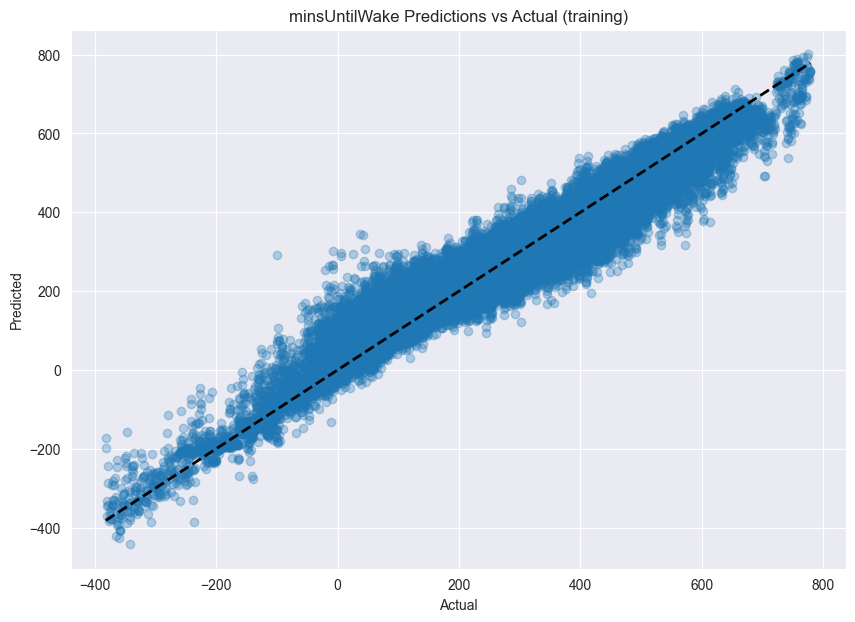

minsUntilWake Validation Set Evaluation:
MAE: 46.14900643165241, MSE: 4248.019542733258, RMSE: 65.17683286823055


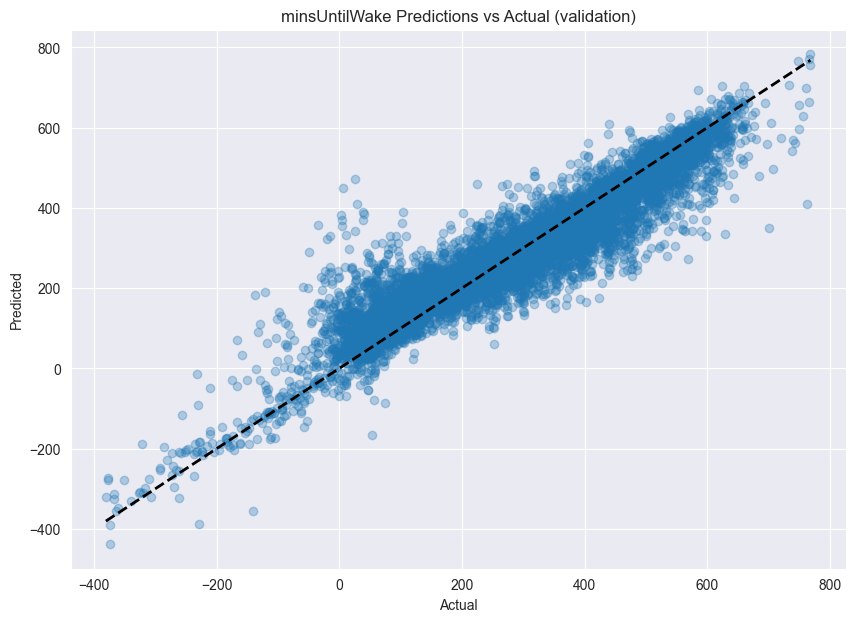

In [12]:
import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)

for md in modelsAndData:
    if md.is_classifier:
        evaluation.evaluate_classification_model(md, md.X_train, md.y_train, md.X_val, md.y_val)
    else:
        evaluation.evaluate_regression_model(md, md.X_train, md.y_train, md.X_val, md.y_val)

 # Save model


In [17]:
modelsAndData[0].X.columns

Index(['HR', 'HrvRMSSDSomewhatRecent', 'Main_eeg_abspow_c7min_norm_s',
       'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_abspow_s',
       'Main_eeg_alpha_c7min_norm_s', 'Main_eeg_alpha_p2min_norm_s',
       'Main_eeg_alpha_s', 'Main_eeg_alphaaa_c7min_norm_s',
       'Main_eeg_alphaaa_p2min_norm_s',
       ...
       'Main_eeg_thetaabs_s', 'Main_eeg_thetaabsaa_c7min_norm_s',
       'Main_eeg_thetaabsaa_p2min_norm_s', 'Main_eeg_thetaabsaa_s',
       'Main_eeg_thetaabsab_c7min_norm_s', 'Main_eeg_thetaabsab_p2min_norm_s',
       'Main_eeg_thetaabsab_s', 'Movement', 'O2', 'Temp'],
      dtype='object', length=134)

In [13]:
filenames = []

for md in modelsAndData:
    model_filename = f"models/{md.name}_xgboost_model.cbm"
    log(f"Saving model {md} to {model_filename}")
    md.model.save_model(model_filename)
    filenames.append(model_filename)

for fn in filenames:
    print(f"\"{fn}\",")

"models/minsUntilWake_xgboost_model.cbm",


C:\Users\graha\.conda\envs\tf\lib\site-packages\xgboost\core.py:158: UserWarning: [05:41:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


# Most useful features

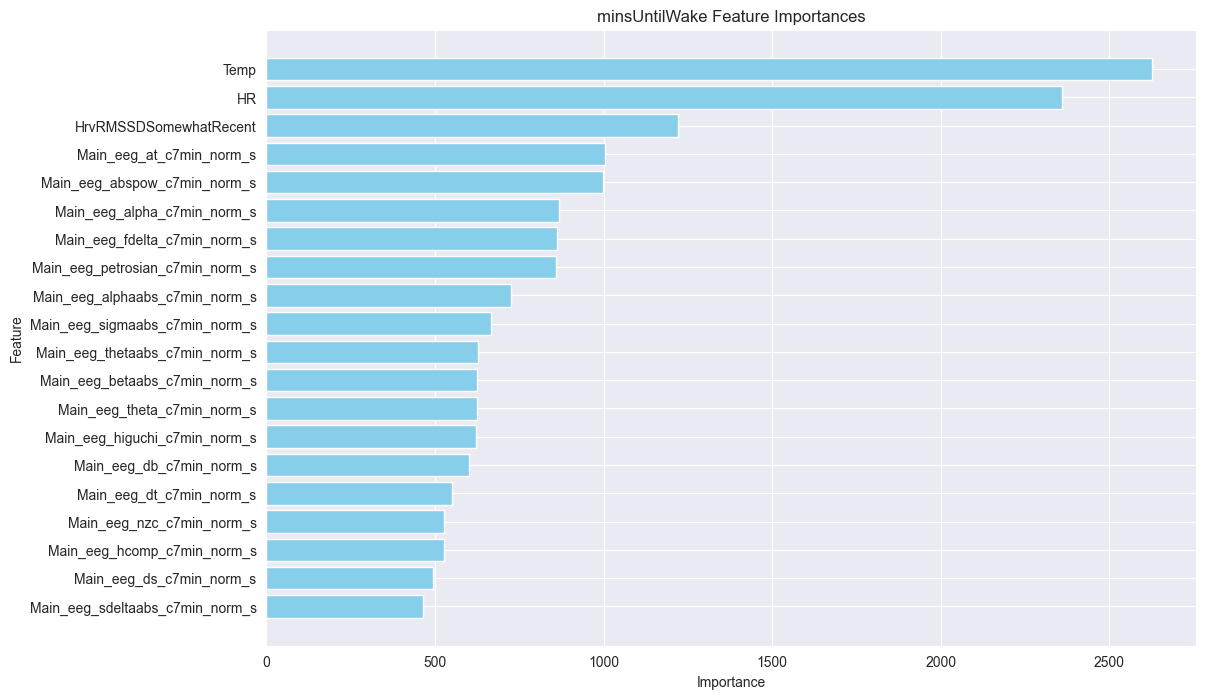

In [14]:
import models.util.importances as importances
from importlib import reload
reload(importances)
    
for md in modelsAndData:
    imp = importances.xgboost_importances(md)[0:20]
    importances.plot_importances(imp, md.name)

In [15]:
Ypetest_md = modelsAndData[0]

In [16]:
import seaborn as sns
sns.scatterplot(x='Main_eeg_perment_s', y=test_md.target_col, data=test_md.prepared_df)


NameError: name 'test_md' is not defined

In [75]:
test_md.prepared_df

,Confidence_x,F8-M1_Confidence_x,T4-M1_Confidence_x,O2-M1_Confidence_x,StageInt_x,Main_eeg_abspow_s,Main_eeg_abspow_c7min_norm_s,Main_eeg_abspow_p2min_norm_s,Main_eeg_alpha_s,Main_eeg_alpha_c7min_norm_s,...,Fpz-M1_Confidence_x,F4-M1_Confidence_x,Fpz-M1_Confidence_y,F4-M1_Confidence_y,SettlingEventMatchedIdx,SettlingManualScore,SettlingV4ManualScore,TiredVsAlertManualScore,SettlingV4ScorePrediction,WillWakeWithin60Mins
2,0.999987,0.999951,0.999987,0.999412,0,0.673643,0.631520,1.210844,0.074071,-0.139941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,0.999875,0.999564,0.999875,0.997296,0,0.740908,0.620911,1.136667,0.091764,-0.137007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,0.999843,0.998763,0.999843,0.996956,0,0.417889,0.609999,0.669285,0.161176,-0.133391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5,0.999532,0.998831,0.999532,0.997687,0,0.577379,0.604815,0.731069,0.068022,-0.130382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
7,0.999465,0.998943,0.999465,0.987641,0,0.811312,0.654045,0.744720,0.098874,-0.120942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,0.999282,NaN,NaN,NaN,0,0.279018,1.278017,2.111404,0.099304,-0.030497,...,0.999282,NaN,0.999282,NaN,NaN,NaN,NaN,NaN,1.0,False
1145,0.997849,NaN,NaN,NaN,0,1.149445,1.162454,1.264398,-0.015355,-0.004882,...,0.997849,NaN,0.997849,NaN,NaN,NaN,NaN,NaN,1.0,False
1146,0.997343,NaN,NaN,NaN,0,0.348046,1.017307,0.871481,0.121749,0.027155,...,0.997343,NaN,0.997343,NaN,NaN,NaN,NaN,NaN,1.0,False
1147,0.998733,NaN,NaN,NaN,0,0.595378,0.870215,0.761752,0.069582,0.060004,...,0.998733,NaN,0.998733,NaN,NaN,NaN,NaN,NaN,1.0,False


<Axes: xlabel='TimeToReadyToSleepMins', ylabel='Main_eeg_perm_s'>

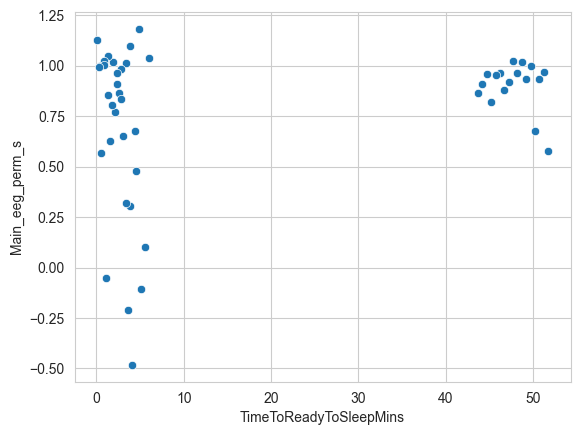

In [160]:
day1 =  test_md.prepared_df[0:48]
sns.scatterplot(y='Main_eeg_perm_s', x=target_cols[1], data=day1)


In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_avg_feature(df, col_name, ax, max_time_to_ready_to_sleep_mins=50):
    # Create a new column with the integer version of the x values
    df2 = df.copy()
    df2['TimeToReadyToSleepMins_int'] = df2['TimeToReadyToSleepMins'].astype(int)
    df2 = df2[df2['TimeToReadyToSleepMins_int'] <= max_time_to_ready_to_sleep_mins]

    # Group by the integer version of x and calculate the mean for each group
    grouped = df2.groupby('TimeToReadyToSleepMins_int').mean().reset_index()

    # Plot the average value for each integer version of x with a linear regression line
    sns.regplot(x='TimeToReadyToSleepMins_int', y=col_name, data=grouped, ax=ax, scatter_kws={'s': 10})
    ax.set_title(col_name)

# Calculate Pearson correlation for each column
correlations = test_md.prepared_df.corr()['TimeToReadyToSleepMins'].drop('TimeToReadyToSleepMins').sort_values(ascending=False)

# Get the list of columns to plot, ordered by Pearson correlation
columns_to_plot = correlations.index

# Create a figure and axes for the subplots
num_cols = 4
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(columns_to_plot):
    plot_avg_feature(test_md.prepared_df, col, axes[i])

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

KeyError: 'TimeToReadyToSleepMins'

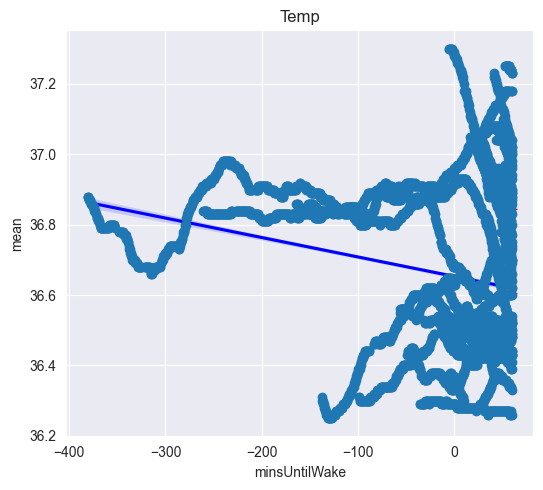

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_avg_feature(df, col_name, ax, max_time=60):
    # Create a new column with the integer version of the x values
    df2 = df.copy()
    df2 = df2[df2['minsUntilWake'] <= max_time]
    grouped = df2.groupby('minsUntilWake').agg({col_name: ['mean', 'std']}).reset_index()
    grouped.columns = ['minsUntilWake', 'mean', 'std']

    # Plot the average value for each integer version of x with error bars
    ax.errorbar(grouped['minsUntilWake'], grouped['mean'], yerr=grouped['std'], fmt='o', ecolor='r', capsize=5)
    sns.regplot(x='minsUntilWake', y='mean', data=grouped, ax=ax, scatter=False, line_kws={'color': 'blue'})
    ax.set_title(col_name)

# Calculate Pearson correlation for each column
# correlations = test_md.prepared_df.corr()['TimeToReadyToSleepMins'].drop('TimeToReadyToSleepMins').sort_values(ascending=False)

# Get the list of columns to plot, ordered by Pearson correlation
# columns_to_plot = correlations.index
columns_to_plot = ['Temp']

# Create a figure and axes for the subplots
num_cols = 4
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(columns_to_plot):
    plot_avg_feature(merged, col, axes[i])

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

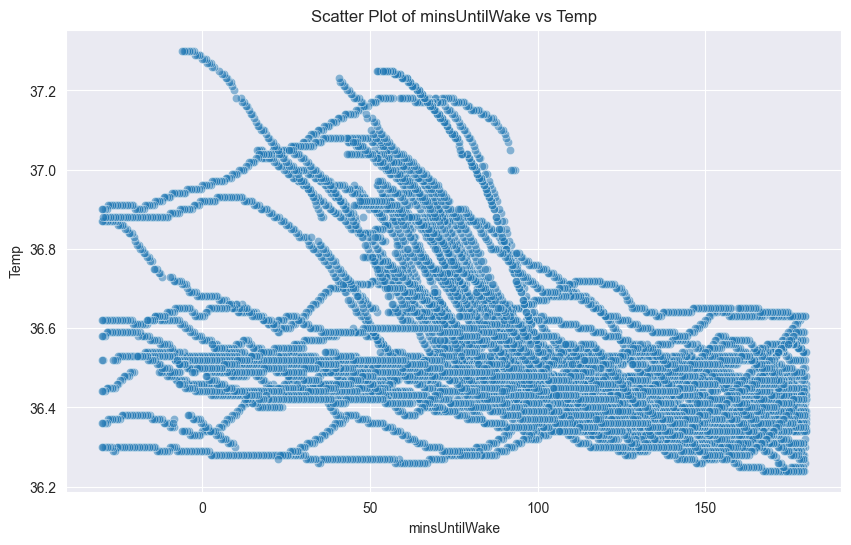

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for minsUntilWake <= 60
filtered_df = merged[(merged['minsUntilWake'] <= 180) & (merged['minsUntilWake'] >= -30)]

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='minsUntilWake', y='Temp', data=filtered_df, alpha=0.5)
plt.title('Scatter Plot of minsUntilWake vs Temp')
plt.xlabel('minsUntilWake')
plt.ylabel('Temp')
plt.show()

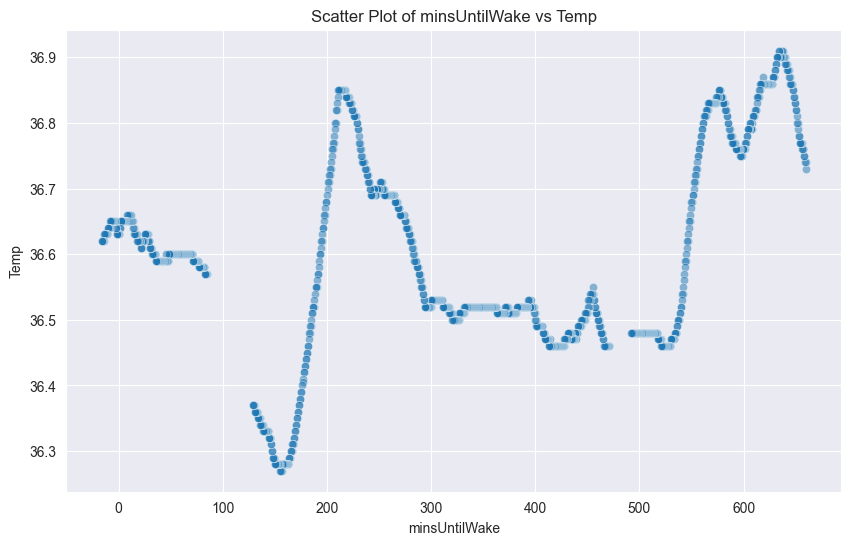

In [101]:
df = merged[merged['dayAndNightOf'] == '2024-12-05']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='minsUntilWake', y='Temp', data=df, alpha=0.5)
plt.title('Scatter Plot of minsUntilWake vs Temp')
plt.xlabel('minsUntilWake')
plt.ylabel('Temp')
plt.show()
